# Day 27 - Introducing generative models

## Transformers

### The Decoder

* The decoder-only GPT is similar to our previous attention model, with three additions:
    1. Residual connections
    2. Multiheaded attention
    3. Layer normalization

In [1]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
names = []
with open('./DLPT/data/text/names/yob2023.txt', 'r') as file:
    for line in file:
        name, _, _= line.lower().strip().split(',')
        names.append("$" + name + "$")

In [3]:
vocab = "$abcdefghijklmnopqrstuvwxyz"
vocab_size = len(vocab)

ch_to_i = {ch: i for i, ch in enumerate(vocab)}
i_to_ch = {i: ch for i, ch in enumerate(vocab)}

In [4]:
encode = lambda word: torch.tensor([ch_to_i[c] for c in word])
decode = lambda tensor_i: ''.join(i_to_ch[i.item()] for i in tensor_i)

name_indices = [encode(name) for name in names]
target_indices = [name_index[1:] for name_index in name_indices]

In [5]:
from torch.nn.utils.rnn import pad_sequence

X = pad_sequence(name_indices, batch_first=True, padding_value=0)
max_name_length = max(len(name) for name in names)
target_indices.append(torch.empty((max_name_length), dtype=torch.long))
Y = pad_sequence(target_indices, batch_first=True, padding_value=-1)[:-1]

In [6]:
def get_batch(batch_size=64):
    random_idx = torch.randint(0, X.size(0), (batch_size,))
    inputs = X[random_idx]
    labels = Y[random_idx]
    return inputs, labels

In [7]:
from tqdm.auto import tqdm


def train(model, optimizer, num_steps=10_000, loss_report_interval=1_000):
    losses = []
    alpha = 2 / (num_steps + 1)
    
    for i in tqdm(range(1, num_steps + 1), desc="Epochs"):
        device = next(model.parameters()).device
        
        inputs, labels = get_batch()
        inputs = inputs.to(device=device, non_blocking=True)
        labels = labels.to(device=device, non_blocking=True)
        
        optimizer.zero_grad()
        logits = model(inputs)
        loss = F.cross_entropy(logits.view(-1, logits.shape[-1]),
                               labels.view(-1), ignore_index=-1)
        loss.backward()
        optimizer.step()

        if i == 1:
            losses.append(loss.item())
        else:
            losses.append(losses[i-2] * (1 - alpha) + loss.item() * alpha)
        
        if i == 1 or i == num_steps or i % loss_report_interval == 0:
            print(f'Average loss at step {i}: {losses[i-1]:.4f}')

    return losses

In [8]:
from torch import nn
import torch.nn.functional as F


class TransformerBlock(nn.Module):
    def __init__(self, n_embd, num_heads=4, n_hidden=64):
        super().__init__()
        assert n_embd % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.num_heads = num_heads
        self.head_dim = n_embd // num_heads

        self.query_proj = nn.Linear(n_embd, n_embd)
        self.key_proj = nn.Linear(n_embd, n_embd)
        self.value_proj = nn.Linear(n_embd, n_embd)

        self.mlp = nn.Sequential(
            nn.Linear(n_embd, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_embd),
        )

        self.norm_1 = nn.LayerNorm(n_embd)
        self.norm_2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        batch_size, sequence_length, _ = x.shape

        q = self.query_proj(x)
        k = self.key_proj(x)
        v = self.value_proj(x)

        q = q.view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)

        attn_weights = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        attn_weights = attn_weights.transpose(1, 2).contiguous().view(batch_size, sequence_length, -1)

        out = self.norm_1(x + attn_weights)
        return self.norm_2(out + self.mlp(out))

In [9]:
class Transformer(nn.Module):
    def __init__(self, n_embd, vocab_size, block_size, num_blocks=6, num_heads=4, n_hidden=64):
        super().__init__()
        self.char_embedding = nn.Embedding(vocab_size, n_embd)
        self.positional_embedding = nn.Embedding(block_size, n_embd)

        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(n_embd, num_heads, n_hidden) for _ in range(num_blocks)]
        )

        self.output_proj = nn.Linear(n_embd, vocab_size)

    def forward(self, x):
        device = self.output_proj.weight.device
        
        _, seq_len = x.shape

        char_embd = self.char_embedding(x)
        pos_embd = self.positional_embedding(torch.arange(seq_len, device=device))
        
        out = char_embd + pos_embd
        out = self.transformer_blocks(out)
        return self.output_proj(out)

In [10]:
from torch import optim

num_heads = 4
n_embd = 16 * num_heads
num_blocks = 6
n_hidden = 64

model = Transformer(
    n_embd,
    vocab_size,
    block_size=max_name_length,
    num_blocks=num_blocks,
    num_heads=num_heads,
    n_hidden=n_hidden
).to(device=device)

model.compile(fullgraph=True)
torch.set_float32_matmul_precision('high')

In [11]:
print(f"{sum(p.numel() for p in model.parameters()):,}")

130,907


In [12]:
model.train()

optimizer = optim.SGD(model.parameters(), lr=1e-1)
losses = train(model, optimizer, num_steps=100_000, loss_report_interval=10_000)

Epochs:   0%|          | 0/100000 [00:00<?, ?it/s]

Average loss at step 1: 3.5188
Average loss at step 10000: 3.2528
Average loss at step 20000: 2.9995
Average loss at step 30000: 2.7756
Average loss at step 40000: 2.5833
Average loss at step 50000: 2.4205
Average loss at step 60000: 2.2837
Average loss at step 70000: 2.1692
Average loss at step 80000: 2.0734
Average loss at step 90000: 1.9936
Average loss at step 100000: 1.9269


In [13]:
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
from utils import plot_training_loss
sns.set_theme()

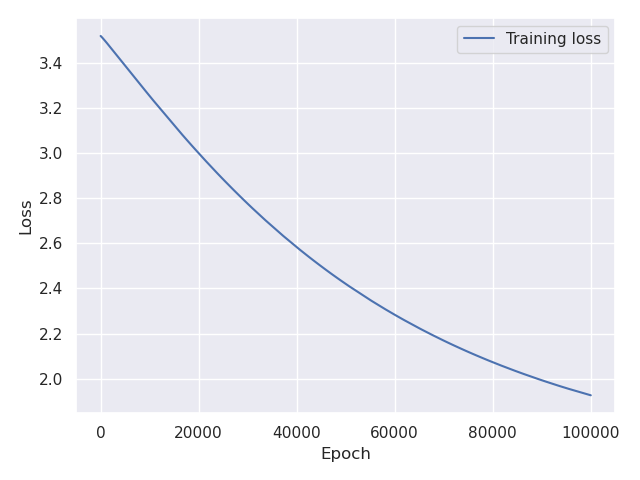

In [14]:
fig, ax = plt.subplots()
plot_training_loss(losses, ax)
plt.tight_layout()
plt.show()

In [15]:
def generate_samples(model, num_samples=1, max_len=max_name_length):
    device = next(model.parameters()).device
    
    sequences = torch.zeros((num_samples, 1), device=device).int()
    
    for _ in range(max_len):
        logits = model(sequences)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        sequences = torch.cat((sequences, idx_next), dim=1)

    for sequence in sequences:
        indices = torch.where(sequence == 0)[0]
        end = indices[1] if len(indices) > 1 else max_len
        sequence = sequence[1:end]
        
        print(decode(sequence))

In [16]:
model.eval()
generate_samples(model, num_samples=10)

noria
pyrrha
araiyah
an
anandi
milla
schnen
zivenna
isys
birge


## Tokenization

* The task of tokenization is complex, but huggingface provides the `tokenizer` library